In [0]:
!wget 'https://www.dropbox.com/s/m9nobjfgq86obmo/train_file.csv'
!wget 'https://www.dropbox.com/s/40cv3eh63df6igg/test_file.csv'

In [0]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [0]:
train_file= pd.read_csv('/content/train_file.csv')
test_file= pd.read_csv('/content/test_file.csv')

In [0]:
train_file['data']= 'train'
test_file['data']= 'test'
test_file['is_promoted']= np.nan

In [0]:
train_file.shape, test_file.shape

((54808, 15), (23490, 15))

In [0]:
full= pd.concat([train_file, test_file], axis=0)

In [0]:
full.head()

,KPIs_met >80%,age,avg_training_score,awards_won?,data,department,education,employee_id,gender,is_promoted,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,region
0,1,35,49,0,train,Sales & Marketing,Master's & above,65438,f,0.0,8,1,5.0,sourcing,region_7
1,0,30,60,0,train,Operations,Bachelor's,65141,m,0.0,4,1,5.0,other,region_22
2,0,34,50,0,train,Sales & Marketing,Bachelor's,7513,m,0.0,7,1,3.0,sourcing,region_19
3,0,39,50,0,train,Sales & Marketing,Bachelor's,2542,m,0.0,10,2,1.0,other,region_23
4,0,45,73,0,train,Technology,Bachelor's,48945,m,0.0,2,1,3.0,other,region_26


In [0]:
full.shape

(78298, 15)

## **Preprocessing steps**

In [0]:
full.isnull().sum()

KPIs_met >80%               0
age                         0
avg_training_score          0
awards_won?                 0
data                        0
department                  0
education                3443
employee_id                 0
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating     5936
recruitment_channel         0
region                      0
dtype: int64

From above, we see that **education** and **previous_year_rating** column has missing values. 

Let's replace the missing values using mode.

In [0]:
full['education'].mode()

0    Bachelor's
dtype: object

In [0]:
 full['previous_year_rating'].mode()

0    3.0
dtype: float64

In [0]:
full['education'].fillna("Bachelor's", inplace=True)
full['previous_year_rating'].fillna(3.0, inplace=True)

In [0]:
full.isnull().sum()

KPIs_met >80%               0
age                         0
avg_training_score          0
awards_won?                 0
data                        0
department                  0
education                   0
employee_id                 0
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating        0
recruitment_channel         0
region                      0
dtype: int64

In [0]:
#Lets change the previous_year_rating column to INT.
full['previous_year_rating']= full['previous_year_rating'].astype(int)

In [0]:
full.dtypes

KPIs_met >80%             int64
age                       int64
avg_training_score        int64
awards_won?               int64
data                     object
department               object
education                object
employee_id               int64
gender                   object
is_promoted             float64
length_of_service         int64
no_of_trainings           int64
previous_year_rating      int64
recruitment_channel      object
region                   object
dtype: object

**Creating Dummies for the categorical columns..**

In [0]:
cat_cols= ['department', 'region', 'education', 'gender', 'recruitment_channel']

In [0]:
for col in cat_cols:
  k= full[col].value_counts()
  cats= k.index[k>30][:-1]
  for cat in cats:
    name= col+'_'+cat
    full[name]= (full[col]==cat).astype(int)
  del full[col]

In [0]:
full.head()

,KPIs_met >80%,age,avg_training_score,awards_won?,data,employee_id,is_promoted,length_of_service,no_of_trainings,previous_year_rating,department_Sales & Marketing,department_Operations,department_Procurement,department_Technology,department_Analytics,department_Finance,department_HR,department_Legal,region_region_2,region_region_22,region_region_7,region_region_15,region_region_13,region_region_26,region_region_31,region_region_4,region_region_27,region_region_16,region_region_28,region_region_11,region_region_23,region_region_29,region_region_32,region_region_19,region_region_14,region_region_20,region_region_17,region_region_25,region_region_5,region_region_6,region_region_30,region_region_8,region_region_10,region_region_1,region_region_24,region_region_12,region_region_9,region_region_21,region_region_3,region_region_34,region_region_33,education_Bachelor's,education_Master's & above,gender_m,recruitment_channel_other,recruitment_channel_sourcing
0,1,35,49,0,train,65438,0.0,8,1,5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,30,60,0,train,65141,0.0,4,1,5,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
2,0,34,50,0,train,7513,0.0,7,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,0,39,50,0,train,2542,0.0,10,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
4,0,45,73,0,train,48945,0.0,2,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


In [0]:
full.shape

(78298, 56)

**After done with Preprocessing steps, lets split the data again back to TRAIN and TEST file**

In [0]:
train_file= full[full['data']=='train']
del train_file['data']
test_file= full[full['data']=='test']
test_file.drop(['is_promoted', 'data'], axis=1, inplace=True)

In [0]:
train_file.shape, test_file.shape

((54808, 55), (23490, 54))

## **Exploratory Data Analysis -- EDA**

In [0]:
train= pd.read_csv('/content/train_file.csv')

In [0]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [0]:
train['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [0]:
train['region'].value_counts().shape

(34,)

In [0]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [0]:
train['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [0]:
train['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [0]:
train['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [0]:
train['KPIs_met >80%'].value_counts()

0    35517
1    19291
Name: KPIs_met >80%, dtype: int64

In [0]:
train['awards_won?'].value_counts()

0    53538
1     1270
Name: awards_won?, dtype: int64

In [0]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

## ***Feature Selection***

In [0]:
df= train_file.copy()

In [0]:
#Importing required packages..
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [0]:
X= df.drop(['employee_id', 'is_promoted'], axis=1)
Y= df['is_promoted']

In [0]:
#Splitting the data into train and test...
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, random_state=22, stratify=Y)

In [0]:
lr= LogisticRegression(class_weight={0:1., 1:50.})

In [0]:
lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 50.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predicted= lr.predict(X_test)

In [0]:
roc_auc_score(Y_test, predicted) , accuracy_score(Y_test, predicted)

(0.7558207468766256, 0.5692391899288451)

We see that by using all the available features we get a **ROC_AUC_SCORE of 75%**.

Now lets look at a **Feature Importance plot** highlighting the top 15 important features to predict our target variable.

In [0]:
et= ExtraTreesClassifier(class_weight={0:1., 1:50.})

In [0]:
et.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight={0: 1.0, 1: 50.0}, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

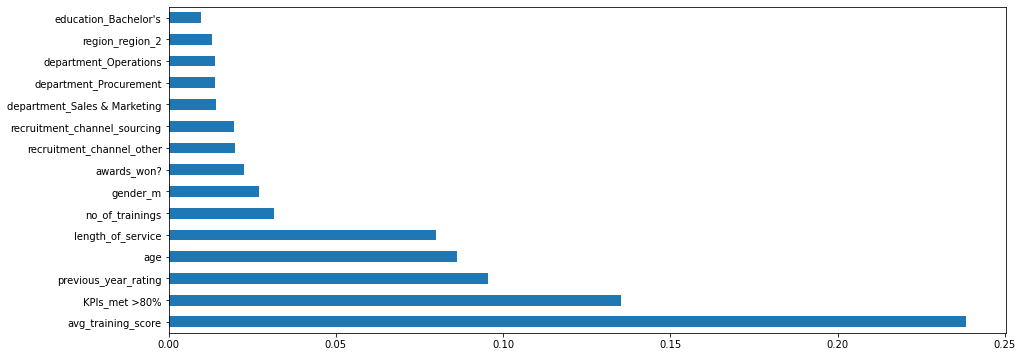

In [0]:
feat_importance= pd.Series(et.feature_importances_, index=X_train.columns)
feat_importance.nlargest(15).plot(kind='barh', figsize=(15,6))
plt.show()

Now lets use **Recursive Feature Elimination** method to eliminate the features which doesn't contribute much in predicting our Target variable.

In [0]:
rfe= RFE(lr, 10)
fit= rfe.fit(X_train, Y_train)

In [0]:
print('Num features: %d' %fit.n_features_)
print('Feature Ranking: %s' %fit.ranking_)

Num features: 10
Feature Ranking: [ 1 42 33  1 44 26 10 31 36 25 12 27 35  9  3 17 38 37 14 20 13  5 21 15
 11 30  2 34  1  1  8 39  1 32 24  6  1 16 18 19 41  4  7  1  1 40  1  1
 28 29 43 23 22]


Here we took Linear Regression model with 10 features and RFE gave feature ranking as above, but the selection of number 7 was random.

Now we need to find the optimum number of features, for which the accuracy is highest. We do that by using loop starting with 1 feature and going up to 55.

We then take the one for which the accuracy is highest.

In [0]:
#No. of features
nof_list= np.arange(1,55)
high_score= 0
#Variable to store the optimum features.
nof=10
score_list= []
for n in range(len(nof_list)):
  model= LogisticRegression(class_weight={0:1., 1:50.})
  rfe= RFE(model, nof_list[n])
  X_train_rfe= rfe.fit_transform(X_train, Y_train)
  X_test_rfe= rfe.transform(X_test)
  model.fit(X_train_rfe, Y_train)
  score= model.score(X_test_rfe, Y_test)
  score_list.append(score)
  if (score>high_score):
    high_score= score
    nof= nof_list[n]

print('Optimum num of features: %d' %nof)
print('Score with %d features: %f' %(nof, high_score))

Optimum num of features: 44
Score with 44 features: 0.598248


We now feed 44 as the number of features to RFE and get the final set of features given by RFE method, as follows:

In [0]:
cols= list(X.columns)
model= LogisticRegression(class_weight={0:1., 1:50.})

#Initializing RFE model..
rfe= RFE(model, 44)

#Transforming data using RFE
X_rfe= rfe.fit_transform(X_train, Y_train)

#Fitting the data to model..
model.fit(X_rfe, Y_train)
temp= pd.Series(rfe.support_, index=cols)
selected_features_rfe= temp[temp==True].index
print(selected_features_rfe)

Index(['KPIs_met >80%', 'avg_training_score', 'awards_won?', 'no_of_trainings',
       'previous_year_rating', 'department_Sales & Marketing',
       'department_Procurement', 'department_Technology',
       'department_Analytics', 'department_Finance', 'department_HR',
       'department_Legal', 'region_region_2', 'region_region_15',
       'region_region_13', 'region_region_26', 'region_region_31',
       'region_region_4', 'region_region_27', 'region_region_16',
       'region_region_28', 'region_region_11', 'region_region_23',
       'region_region_29', 'region_region_32', 'region_region_19',
       'region_region_20', 'region_region_17', 'region_region_25',
       'region_region_5', 'region_region_6', 'region_region_30',
       'region_region_8', 'region_region_10', 'region_region_24',
       'region_region_12', 'region_region_9', 'region_region_21',
       'region_region_34', 'region_region_33', 'education_Bachelor's',
       'education_Master's & above', 'recruitment_channel_oth

Hence, we conclude that the above **44** features would be used in our Model builing process.

## ***Model Building***

### **Using Logistic Regression**

In [0]:
X_rfe= df[selected_features_rfe]
Y_rfe= df['is_promoted']

In [0]:
#Splitting the data into TRAIN and TEST...
X_train_rfe, X_test_rfe, Y_train_rfe, Y_test_rfe= train_test_split(X_rfe, Y_rfe, test_size=0.2, random_state=11, stratify=Y_rfe)

In [0]:
lr= LogisticRegression(class_weight={0:1., 1:50.})

In [0]:
lr.fit(X_train_rfe, Y_train_rfe)

LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 50.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predicted_rfe= lr.predict(X_test_rfe)
predicted_rfe

array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
roc_auc_score(Y_test_rfe, predicted_rfe), accuracy_score(Y_test_rfe, predicted_rfe)

(0.7593083050541993, 0.5720671410326583)

### **Using Random Forest**

In [0]:
#Importing required packages..
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [0]:
rf= RandomForestClassifier(verbose=1, n_jobs=-1, random_state=10, class_weight={0:1., 1:50.})

In [0]:
params= {
    'n_estimators': [500,700,900],
    'bootstrap': [True, False],
    'max_depth': [None, 2,5,7],
    'min_samples_split': [12,15,18,20],
    'min_samples_leaf': [3,5,7,9],
    'max_features': [12,16,20,25]
}

In [0]:
random_search= RandomizedSearchCV(rf, cv=5, param_distributions=params, n_iter=10, scoring='roc_auc')

In [0]:
random_search.fit(X_train_rfe, Y_train_rfe)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   10.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | ela

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={0: 1.0,
                                                                  1: 50.0},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                  

In [0]:
rf_best= random_search.best_estimator_

In [0]:
#Using the report function given below we can see the cv performance of top few models 
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
report(random_search.cv_results_,3)

Model with rank: 1
Mean validation score: 0.885 (std: 0.005)
Parameters: {'n_estimators': 900, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 25, 'max_depth': None, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.851 (std: 0.003)
Parameters: {'n_estimators': 900, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 25, 'max_depth': 5, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.851 (std: 0.004)
Parameters: {'n_estimators': 900, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 25, 'max_depth': 5, 'bootstrap': False}



From above we can see that **Model Rank-1** has best parameters, hence we will take those parameters into consideration.

In [0]:
best_parameters= {'n_estimators': 900, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 25, 'max_depth': None, 'bootstrap': False}

In [0]:
rf_best= RandomForestClassifier(n_estimators= 900, min_samples_split=20, min_samples_leaf=7, max_features=25, max_depth=None , bootstrap=False, 
                                verbose=1, n_jobs=-1, random_state=10, class_weight={0:1., 1:50.})

In [0]:
rf_best.fit(X_train_rfe, Y_train_rfe)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.4min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 50.0}, criterion='gini',
                       max_depth=None, max_features=25, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       n_estimators=900, n_jobs=-1, oob_score=False,
                       random_state=10, verbose=1, warm_start=False)

In [0]:
predicted_rf= rf_best.predict(X_test_rfe)
predicted_rf

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed:    1.3s finished


array([0., 0., 1., ..., 0., 0., 0.])

In [0]:
roc_auc_score(Y_test_rfe, predicted_rf), accuracy_score(Y_test_rfe, predicted_rf)

(0.7952878620803933, 0.7444809341361065)

### **Lets train the entire TRAIN data and predict the TEST file..**

In [0]:
X_train_full= train_file[selected_features_rfe]  #Here we have selected the features which we shortlisted earlier in Feature Engineering part.
Y_train_full= train_file['is_promoted']

In [0]:
X_test_file= test_file[selected_features_rfe]

In [0]:
X_test_file.shape

(23490, 44)

Lets fit the model.

In [0]:
rf_best.fit(X_train_full, Y_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 50.0}, criterion='gini',
                       max_depth=None, max_features=25, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       n_estimators=900, n_jobs=-1, oob_score=False,
                       random_state=10, verbose=1, warm_start=False)

In [0]:
predict_test_file= rf_best.predict(X_test_file)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed:    2.6s finished


In [0]:
employee_id= test_file['employee_id']

In [0]:
my_solution= pd.DataFrame({'employee_id': employee_id , 'is_promoted': predict_test_file})

In [0]:
my_solution= my_solution.style.hide_index()

In [0]:
pd.DataFrame(my_solution).to_csv("/content/solution_file.csv")

### **Using XGBoost**

In [0]:
import xgboost as xgb

In [0]:
xgbst= xgb.XGBClassifier(objective='binary:logistic')

In [0]:
n_iter=10

random_search= RandomizedSearchCV(xgb, verbose=1, n_jobs=-1, cv=5, n_iter= n_iter, scoring='roc_auc', param_distributions= xgb_params)

In [0]:
random_search.fit(X_train_rfe, Y_train_rfe)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'max_delta_step': [0, 1, 2, 5, 10],
                                        'max_depth': [2, 3, 4, 5, 8, 10],
                           

In [0]:
xgb_best= random_search.best_estimator_

In [0]:
xgb_params= {
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'gamma': [i/10.0 for i in range(0,5)],
    'max_depth': [2,3,4,5,8,10],
    'min_child_weight': [1,2,5,10],
    'max_delta_step': [0,1,2,5,10],
    'subsample': [i/10.0 for i in range(5,10)],
    'colsample_bytree': [i/10.0 for i in range(5,10)],
    'colsample_bylevel': [i/10.0 for i in range(5,10)], 
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'scale_pos_weight': [2],
    'n_estimators': [100, 500, 700, 1000]
}

In [0]:
report(random_search.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.901 (std: 0.004)
Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 3, 'max_delta_step': 10, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5}

Model with rank: 2
Mean validation score: 0.900 (std: 0.004)
Parameters: {'subsample': 0.6, 'scale_pos_weight': 2, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 10, 'max_delta_step': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6}

Model with rank: 3
Mean validation score: 0.892 (std: 0.002)
Parameters: {'subsample': 0.5, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 1e-05, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 2, 'max_delta_step': 0, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8}



In [0]:
xgb_best_params= {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 3,
                  'max_delta_step': 10, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5}

In [0]:
xgb_best_classifier= xgb.XGBClassifier(verbose=1, n_jobs=-1, cv=5, n_iter= n_iter, scoring='roc_auc', subsample= 0.8, scale_pos_weight= 2, reg_lambda= 0.1,
                                       reg_alpha= 1, n_estimators= 700, min_child_weight= 5, max_depth= 3, max_delta_step= 10, learning_rate= 0.3, gamma= 0.3, 
                                       colsample_bytree= 0.7, colsample_bylevel=0.5)

In [0]:
xgb_best_classifier.fit(X_test_rfe, Y_test_rfe)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, cv=5, gamma=0.3,
              learning_rate=0.3, max_delta_step=10, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=700, n_iter=10,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=2,
              scoring='roc_auc', seed=None, silent=None, subsample=0.8,
              verbose=1, verbosity=1)

In [0]:
predicted_xgbst= xgb_best_classifier.predict(X_test_rfe)
predicted_xgbst

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
roc_auc_score(Y_test_rfe, predicted_xgbst) , accuracy_score(Y_test_rfe, predicted_xgbst>), f1_score(Y_test_rfe, predicted_xgbst)

(0.7387500224211608, 0.9448093413610655, 0.6022353714661407)

### **Lets train the entire TRAIN data and predict the TEST file..**

In [0]:
xgb_best_classifier.fit(X_train_full, Y_train_full)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, cv=5, gamma=0.3,
              learning_rate=0.3, max_delta_step=10, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=700, n_iter=10,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=2,
              scoring='roc_auc', seed=None, silent=None, subsample=0.8,
              verbose=1, verbosity=1)

In [0]:
predicted_xgb_full= xgb_best_classifier.predict(X_test_file)
predicted_xgb_full

array([0., 0., 0., ..., 0., 0., 1.])

In [0]:
my_solution= pd.DataFrame({'employee_id': employee_id , 'is_promoted': predicted_xgb_full})

In [0]:
pd.DataFrame(my_solution).to_csv("/content/solution_file.csv")

This is a one of the Hackathon dataset from AnalyticsVidhya...

And when Iam trying to predict the unseen data that is test file, the accuracy is still being ~49%.

Eventually, I would be making another try with different algorithms and with different hyperparameter tuning.

### ***                                                                        THE END...***